In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import pandas as pd
import sklearn
import sklearn.svm
import sklearn.metrics
from sklearn.cross_validation import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcess

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV

##Download the data

In [3]:
star_file = np.load("data/RR_Lyrae_data.npz")
star_colors, star_class = star_file['arr_0'], star_file['arr_1']

##Stack the data and store it in a pandas dataframe

In [4]:
stacked = np.hstack((star_colors, star_class.reshape(star_class.shape[0], 1)))
col_names = ['u-g', 'g-r', 'r-i', 'i-z', 'class']
star_df = pd.DataFrame(stacked, columns=col_names)

##Plot the enitre dataset with a pairplot from seaborn

/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


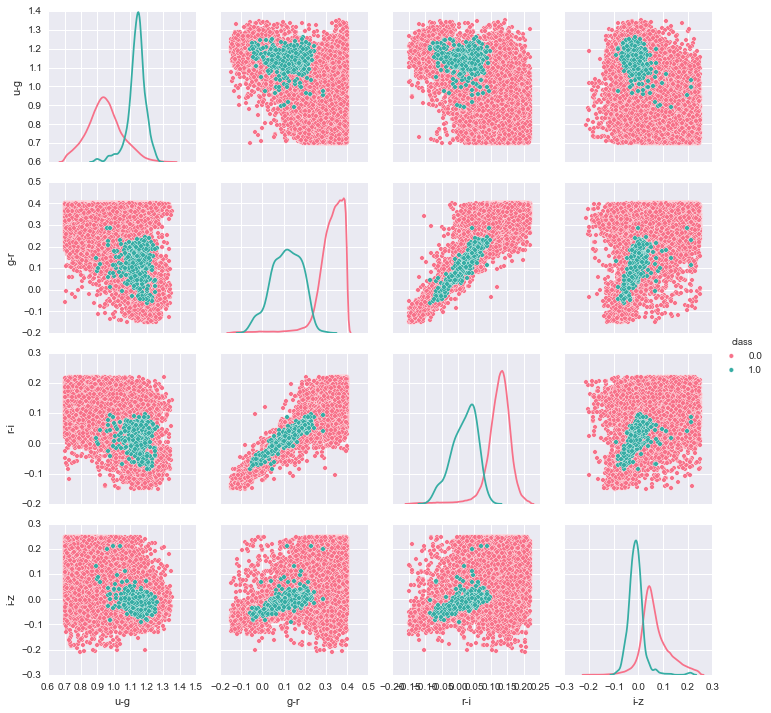

In [5]:
sns.pairplot(star_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

##Divide the data into train and test sets

In [6]:
colors_train, colors_test, labels_train, labels_test = train_test_split(star_colors, star_class, 
                                                                        test_size=0.25, random_state=13)

##Function to compute results

In [7]:
def compute_results(y_true, y_pred):
    fpr, tpr, thresholds_roc = sklearn.metrics.roc_curve(y_true, y_pred, pos_label=1)
    precision_p, recall_p, thresholds_pr = sklearn.metrics.precision_recall_curve(y_true, y_pred, pos_label=1)
    
    y_hard_decisions = np.round(y_pred)
    
    precision = sklearn.metrics.precision_score(y_true, y_hard_decisions)
    recall = sklearn.metrics.recall_score(y_true, y_hard_decisions)
    
    f1 = sklearn.metrics.f1_score(y_true, y_hard_decisions)
    roc_score = sklearn.metrics.roc_auc_score(y_true, y_hard_decisions)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_hard_decisions)
    
    results = {'roc': [fpr, tpr, thresholds_roc],
               'pr': [precision_p, recall_p, thresholds_pr],
               'scores': [precision, recall, f1, roc_score, accuracy]}
    return results

##Functions to train models

In [8]:
def logistic_regression_classification(x_train, y_train, x_test, y_test):
    log_regr = LogisticRegression(class_weight='auto')
    log_regr.fit(x_train, y_train)
    predicted_proba = log_regr.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [9]:
def svm_classification(x_train, y_train, x_test, y_test):
    svm = SVC(kernel='linear', class_weight='auto', probability=True)
    svm.fit(x_train, y_train)
    predicted_proba = svm.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [10]:
def decision_Tree_classification(x_train, y_train, x_test, y_test):
    d_tree = DecisionTreeClassifier(max_depth=12, criterion='entropy')
    d_tree.fit(x_train, y_train)
    predicted_proba = d_tree.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [11]:
def knn_classification(x_train, y_train, x_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    predicted_proba = knn.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [12]:
def random_forest_classification(x_train, y_train, x_test, y_test):
    rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
    rf.fit(x_train, y_train)
    predicted_proba = rf.predict_proba(x_test)[:, 1]
    return compute_results(y_test, predicted_proba)

In [13]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def gaussian_process_classification(x_train, y_train, x_test, y_test):
    gp = GaussianProcess(theta0=20.)
    gp.fit(x_train[::20], y_train[::20])
    pred = gp.predict(x_test)
    probs = sigmoid(pred)
    return compute_results(labels_test, probs)

##Function to run the models and plot the results

In [101]:
def run_models(x_train, y_train, x_test, y_test):
    results = dict()
    
    #RUN Models
    
    #Logistic Regression
    logistic_results = logistic_regression_classification(x_train, y_train, x_test, y_test)
    results['Log Reg'] = logistic_results
    
    # SVM Basically the same as Logistic Regression and takes a while to train
#     svm_results = svm_classification(x_train, y_train, x_test, y_test)
#     results['SVM'] = svm_results
    
    #Decision Tree
    d_tree_resuts = decision_Tree_classification(x_train, y_train, x_test, y_test)
    results['D Tree'] = d_tree_resuts
    
    #KNN
    knn_resuts = knn_classification(x_train, y_train, x_test, y_test)
    results['KNN'] = knn_resuts
    
    #Random Forest
    rf_resuts = random_forest_classification(x_train, y_train, x_test, y_test)
    results['Random Forest'] = rf_resuts
    
#     #Gaussian Process
#     gp_resuts = gaussian_process_classification(x_train, y_train, x_test, y_test)
#     results['GP'] = gp_resuts
    
    # Print reports
    scores = []
    models = []
    for model, results_dict in results.items():
        models.append(model)
        scores.append(results_dict['scores'])
    
    column_names = ['precision', 'recall', 'F1', 'ROC_AUC', 'Accuracy']
    score_df = pd.DataFrame(scores, columns=column_names, index=models)
    #print score_df
    
    fig = plt.figure(figsize=(15, 10))
    #fig.subplots_adjust(hspace=.25)
    ax = fig.add_subplot(121)
    
    for model, result_dict in results.items():
        ax.plot(result_dict['roc'][0], result_dict['roc'][1], label=model)
        
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    ax = fig.add_subplot(122)
    
    #PLOT Precision Recall
    for model, result_dict in results.items():
        plt.plot(result_dict['pr'][0], result_dict['pr'][1], label=model)
               
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    
    ax.legend()
    
    return score_df
    
    
#     #PLOT ROC
#     for model, result_dict in results.items():
#         plt.plot(result_dict['roc'][0], result_dict['roc'][1], label=model)
        
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right')
    
#     plt.figure()
    
#     #PLOT Precision Recall
#     for model, result_dict in results.items():
#         plt.plot(result_dict['pr'][0], result_dict['pr'][1], label=model)
               
#     plt.xlabel('Precision')
#     plt.ylabel('Recall')
#     plt.legend()
    

               precision    recall        F1   ROC_AUC  Accuracy
KNN             0.657407  0.572581  0.612069  0.785492  0.996135
D Tree          0.598361  0.588710  0.593496  0.793297  0.995706
Log Reg         0.139860  0.967742  0.244399  0.967940  0.968135
Random Forest   0.592105  0.362903  0.450000  0.680782  0.995276


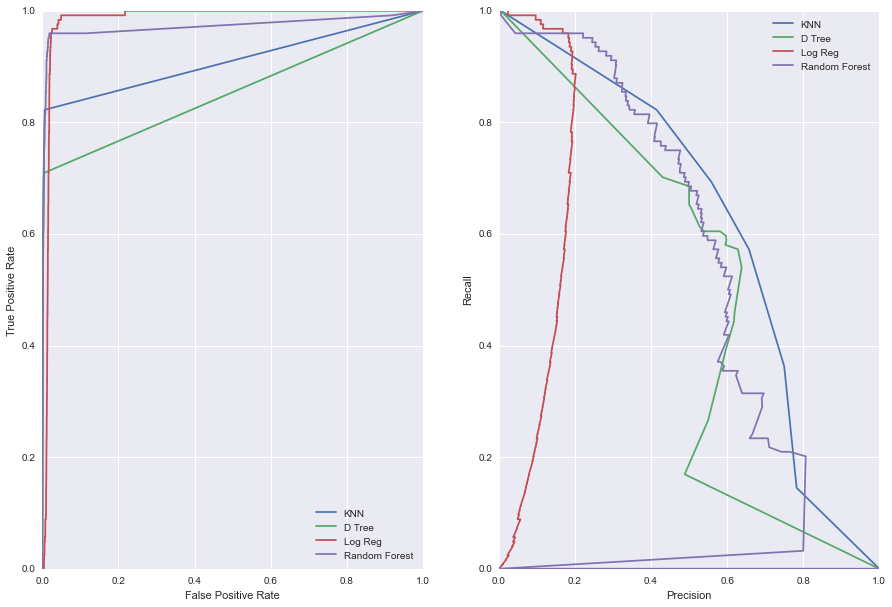

In [102]:
score_df = run_models(colors_train, labels_train, colors_test, labels_test)
print score_df

##Adding new data of RR Stars with KDE

In [16]:
rr_stars = stacked[stacked[:, 4] == 1][:, :-1]

##Optimize KDE with a Gridsearch

In [17]:
params = {'bandwidth': np.logspace(-2, 2, 200)}
grid_kde = GridSearchCV(KernelDensity(), params)
grid_kde.fit(rr_stars)

print("best bandwidth: {0}".format(grid_kde.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid_kde.best_estimator_

best bandwidth: 0.0191164407539


##Sample New data

In [18]:
sampled_rr_stars = kde.sample(450, random_state=0)

In [19]:
def add_class_to_np_array(arr, cls):
    return np.array([np.concatenate([arr[i], [cls]])for i in xrange(arr.shape[0])])

##Plot the generated RR stars versus the actual stars to test the new KDE data

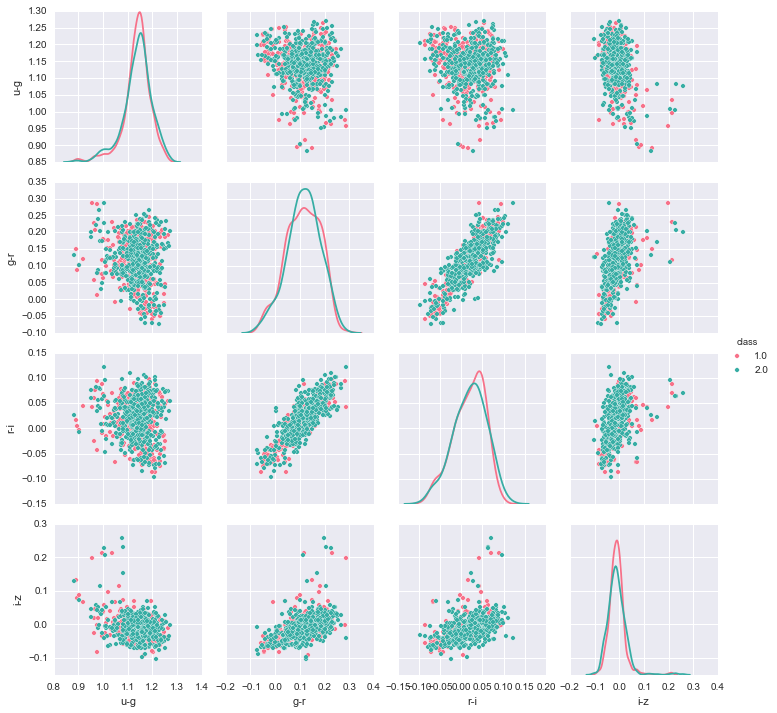

In [20]:
sampled_rr_class = add_class_to_np_array(sampled_rr_stars, 2)
rr_stack = np.vstack([add_class_to_np_array(rr_stars, 1), sampled_rr_class])
rr_df = pd.DataFrame(rr_stack, columns=col_names)
sns.pairplot(rr_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

##Plot the new sampled RR stars with the original data

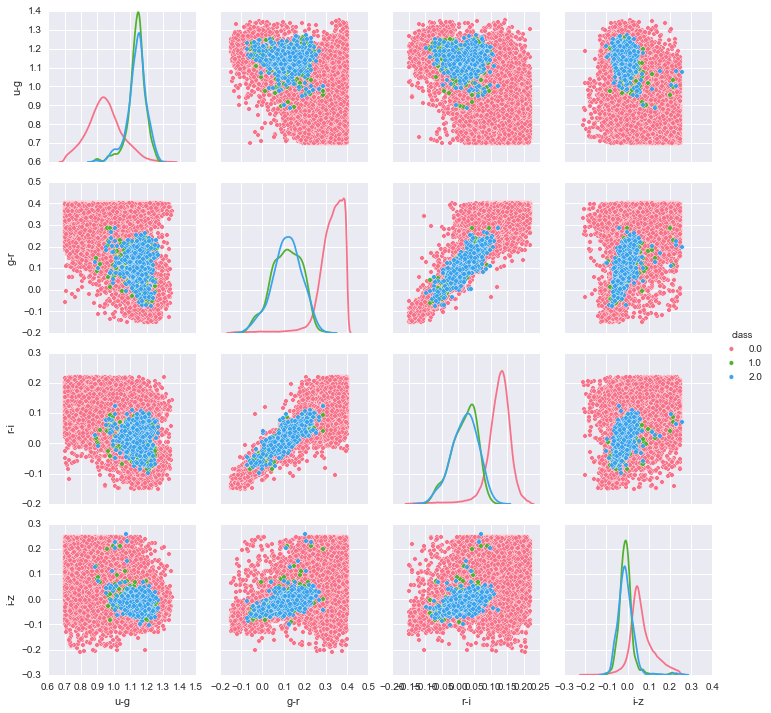

In [21]:
new_data_stack = np.vstack([stacked, sampled_rr_class])
new_data_df = pd.DataFrame(new_data_stack, columns=col_names)
sns.pairplot(new_data_df, hue='class', vars=col_names[:-1], diag_kind="kde", palette='husl')

## Test results with varying amout of kde data

In [103]:
amount_of_new_data = np.arange(1000, 26000, 5000)

In [104]:
def create_added_data_set(amount_new):
    new_rr_stars = kde.sample(amount_new, random_state=0)
    new_rr_with_class = add_class_to_np_array(new_rr_stars, 1)
    new_data = np.vstack([stacked, new_rr_with_class])
    return new_data[:, :-1], new_data[:, -1]


In [148]:
def plot_scores(amount_of_data, score_frames, score_type):
    models = score_frames[0].index
    model_dict = {}
    for m in models:
        model_dict[m] = []
        for df in score_frames:
            model_dict[m].append(df[score_type][m])

    for k, v in model_dict.items():
        plt.plot(amount_of_data, v, label=k)
    plt.legend(loc='lower right')
    plt.xlabel('Amount of new data')
    plt.ylabel(score_type)

Amount of Sampled RR Stars 1000
Amount of Sampled RR Stars 6000
Amount of Sampled RR Stars 11000
Amount of Sampled RR Stars 16000
Amount of Sampled RR Stars 21000


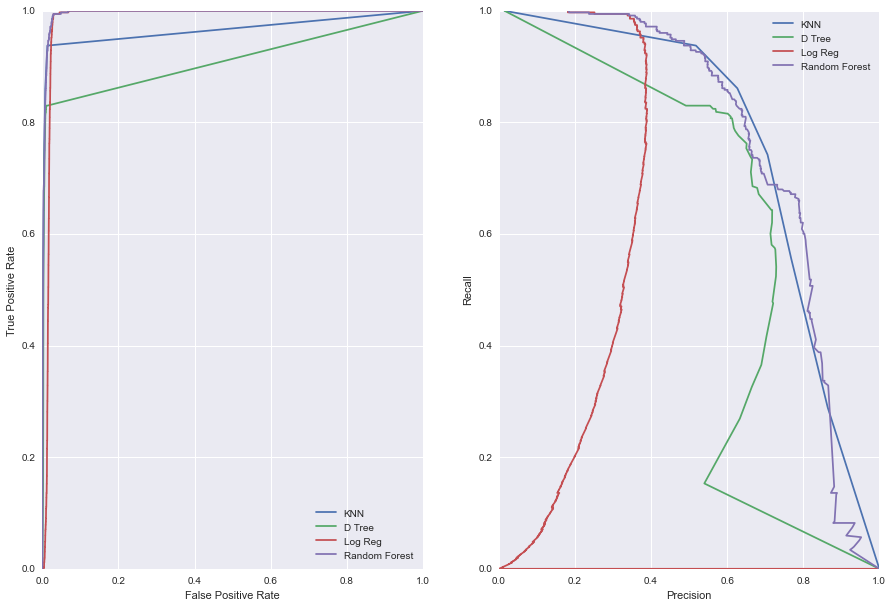

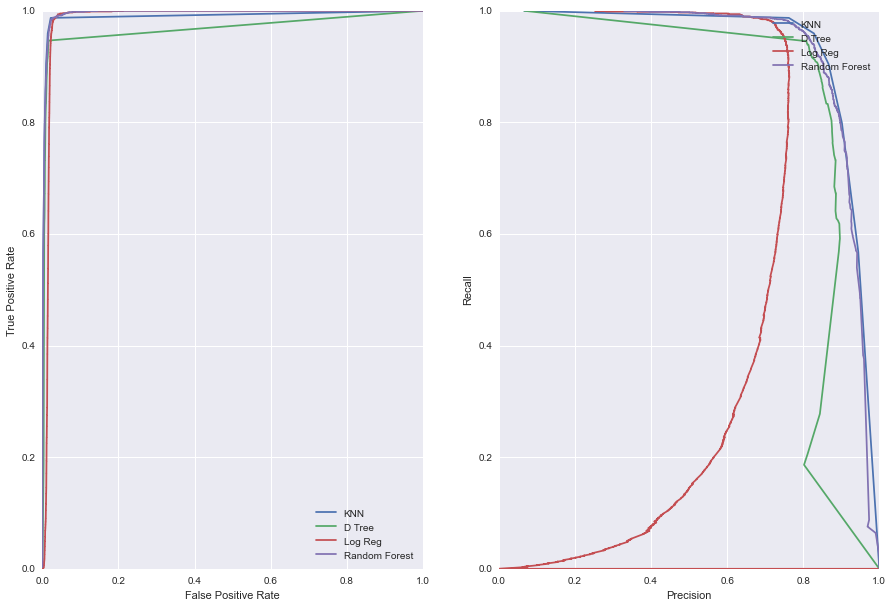

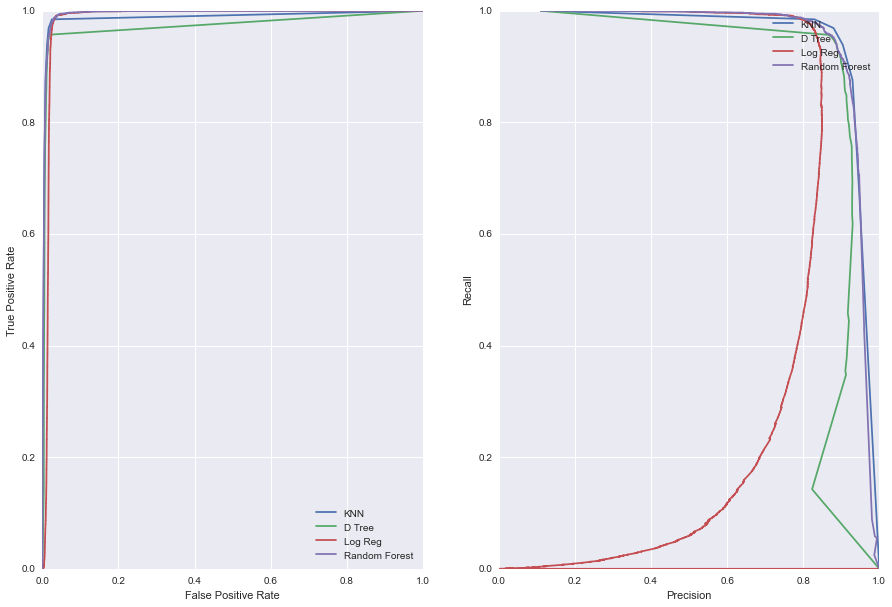

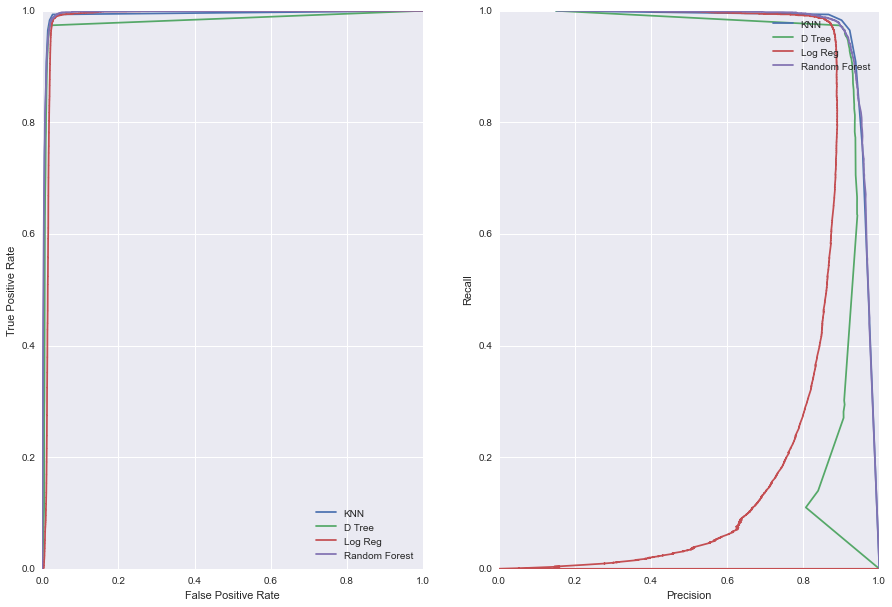

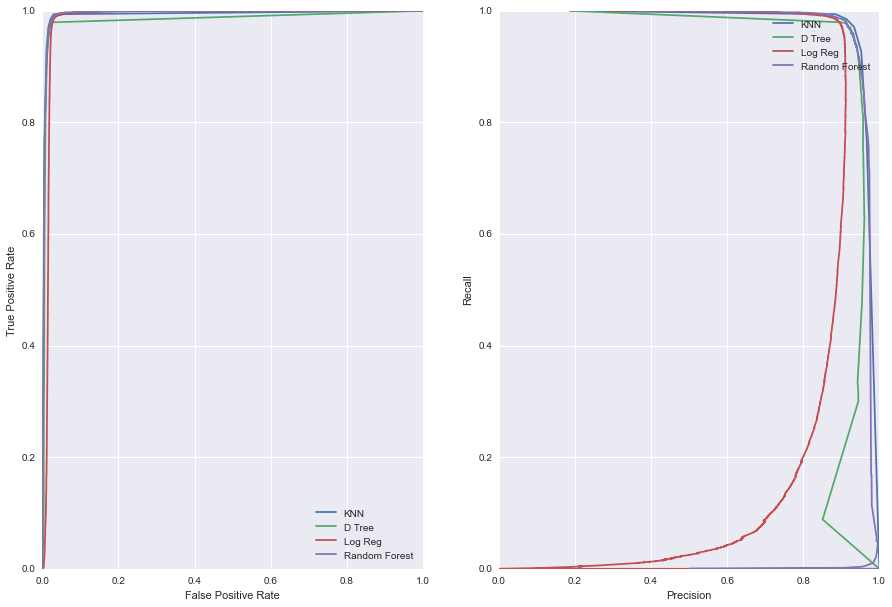

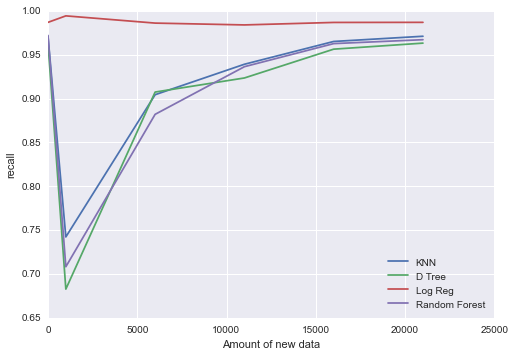

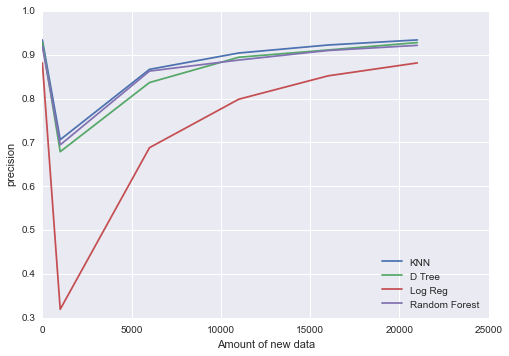

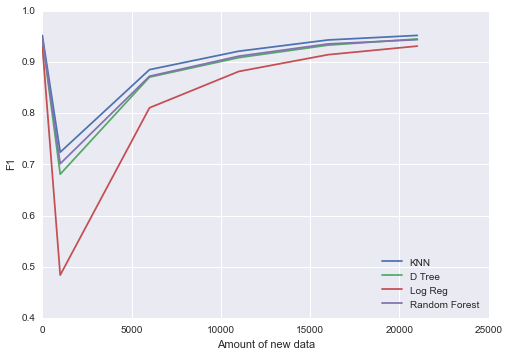

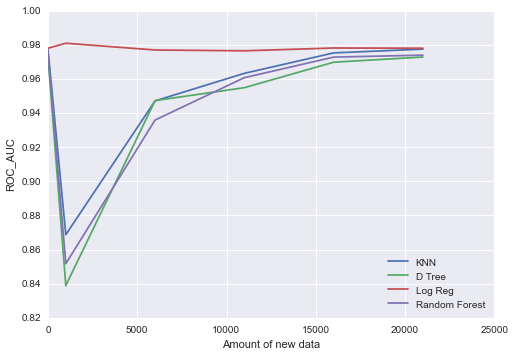

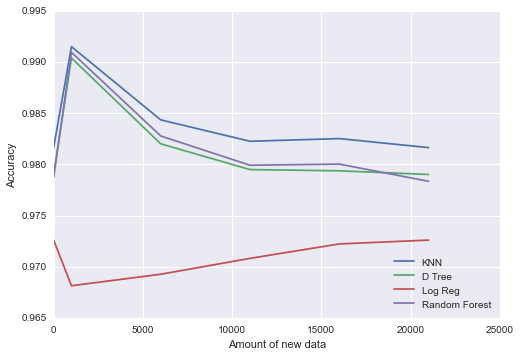

In [152]:
score_frames = [score_df]
for rr_new in amount_of_new_data:
    new_colors, new_labels = create_added_data_set(rr_new)
    colors_train_n, colors_test_n, labels_train_n, labels_test_n = train_test_split(new_colors, new_labels, 
                                                                                    test_size=0.25, random_state=13)
    
    score_df = run_models(colors_train_n, labels_train_n, colors_test_n, labels_test_n)
    score_frames.append(score_df)
    
    print 'Amount of Sampled RR Stars', rr_new
    #print score_df
    
    plt.figure()
    


amount_of_data = np.concatenate([[0], amount_of_new_data])
plot_scores(amount_of_data, score_frames, 'recall')
plt.figure()
plot_scores(amount_of_data, score_frames, 'precision')
plt.figure()
plot_scores(amount_of_data, score_frames, 'F1')
plt.figure()
plot_scores(amount_of_data, score_frames, 'ROC_AUC')
plt.figure()
plot_scores(amount_of_data, score_frames, 'Accuracy')

In [151]:
score_frames[0]

,precision,recall,F1,ROC_AUC,Accuracy
KNN,0.933800,0.971082,0.952076,0.977580,0.981637
D Tree,0.927942,0.963433,0.945355,0.973065,0.979079
Log Reg,0.881373,0.986940,0.931174,0.978109,0.972596
Random Forest,0.924996,0.968657,0.946323,0.975246,0.979359
